In [1]:
import os
import copy
import cogdl
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from cogdl import experiment
from cogdl.utils import set_random_seed
import gsim
import utils

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Load Dataset

In [15]:
from cogdl.datasets import build_dataset_from_path

data_path = "/home/stanislas/dataset/"
dataset_name = "pubmed"
dataset_mode = "inductive"
dataset = build_dataset_from_path(data_path=data_path, dataset=dataset_name)
train_nid = dataset.data.train_nid
val_nid = dataset.data.val_nid
test_nid = dataset.data.test_nid

checkpoint_dir = "./save_models/"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
figure_dir = "./figures/{}".format("exp_0111_{}_64_2_avg".format(dataset_name))
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

## Build model

In [16]:
from custom_models.mlp import MLP
from custom_models.gcn import GCN
from custom_models.sgc import SGC
from custom_models.gin import GIN
from custom_models.appnp import APPNP

In [17]:
models_dict = {'mlp': {}, 'gcn': {}, 'sgc': {}, 'appnp': {}}
hidden_size = 64
num_layers = 2
order = 2
dropout = 0.5
residual = False
remove_self_loop = False
for seed in range(10):
    set_random_seed(seed)
    
    model_name = "mlp/{}/model_mlp_{}_{}_{}_seed_{}".format(dataset_name, hidden_size, num_layers, dropout, seed)
    checkpoint_path = os.path.join(checkpoint_dir, model_name)

    model = MLP(in_feats=dataset.num_features, 
                hidden_size=hidden_size,
                out_feats=dataset.num_classes,
                num_layers=num_layers,
                dropout=dropout)
    models_dict['mlp']['seed_{}'.format(seed)] = {'name': model_name,
                          'model': model,
                          'path': checkpoint_path}
    
    if residual:
        model_name = "model_gcn_res_{}_{}_seed_{}".format(hidden_size, num_layers, seed)
    else:
        model_name = "gcn/{}/model_gcn_{}_{}_{}_seed_{}".format(dataset_name, hidden_size, num_layers, dropout, seed)
    checkpoint_path = os.path.join(checkpoint_dir, "{}".format(model_name))

    model = GCN(in_feats=dataset.num_features, 
                hidden_size=hidden_size,
                out_feats=dataset.num_classes,
                num_layers=num_layers,
                residual=residual,
                dropout=dropout,
                remove_self_loop=remove_self_loop)
    models_dict['gcn']['seed_{}'.format(seed)]  = {'name': model_name,
                          'model': model,
                          'path': checkpoint_path}
    
    model_name = "sgc/{}/model_sgc_{}_{}_{}_seed_{}".format(dataset_name, hidden_size, num_layers, dropout, seed)
    checkpoint_path = os.path.join(checkpoint_dir, "{}".format(model_name))

    model = SGC(in_feats=dataset.num_features, 
                  hidden_size=hidden_size,
                  out_feats=dataset.num_classes,
                  num_layers=num_layers,
                  order=order,
                  dropout=dropout,
                  remove_self_loop=remove_self_loop)
    models_dict['sgc']['seed_{}'.format(seed)] = {'name': model_name,
                                                  'model': model,
                                                  'path': checkpoint_path}
    
    model_name = "appnp/{}/model_appnp_{}_{}_{}_seed_{}".format(dataset_name, hidden_size, num_layers, dropout, seed)
    checkpoint_path = os.path.join(checkpoint_dir, "{}".format(model_name))

    model = APPNP(nfeat=dataset.num_features, 
                  nhid=hidden_size,
                  nclass=dataset.num_classes,
                  num_layers=num_layers,
                dropout=dropout,
                alpha=0.1, 
                 niter=2)
    models_dict['appnp']['seed_{}'.format(seed)] = {'name': model_name,
                                                  'model': model,
                                                  'path': checkpoint_path}
    
#     model_name = "model_gin_{}_{}_k_{}_seed_{}".format(hidden_size, num_layers, order, seed)
#     checkpoint_path = os.path.join(checkpoint_dir, "{}.pt".format(model_name))

#     model = GIN(in_feats=dataset.num_features, 
#                   hidden_dim=hidden_size,
#                   out_feats=dataset.num_classes,
#                   num_layers=num_layers,
#                   num_mlp_layers=2,
#                   dropout=dropout)
#     models_dict['gin']['seed_{}'.format(seed)] = {'name': model_name,
#                                                   'model': model,
#                                                   'path': checkpoint_path}
    
#     for k in models_dict.keys():
#         experiment(model=models_dict[k]['seed_{}'.format(seed)]['model'], dataset=dataset, 
#                    checkpoint_path=models_dict[k]['seed_{}'.format(seed)]['path'], seed=[seed])

## Evaluation

In [18]:
from cogdl.wrappers.model_wrapper.node_classification import NodeClfModelWrapper
from cogdl.utils import spmm

In [19]:
for k in models_dict.keys():
    for seed in range(10):
        model_wrapper = NodeClfModelWrapper(models_dict[k]['seed_{}'.format(seed)]['model'], None)
        model_wrapper.load_state_dict(torch.load(models_dict[k]['seed_{}'.format(seed)]['path']))
        model = model_wrapper.model
        model.eval()
        models_dict[k]['seed_{}'.format(seed)]['model'] = model

### Accuracy, confidence, entropy, perplexity

In [8]:
graph = copy.deepcopy(dataset.data)
graph.add_remaining_self_loops()
plot_labels = []
train_accs_10, val_accs_10, test_accs_10 = [], [], []
train_confs_10, val_confs_10, test_confs_10 = [], [], []
train_entropys_10, val_entropys_10, test_entropys_10 = [], [], []
train_perps_10, val_perps_10, test_perps_10 = [], [], []
verbose = False
for k in models_dict.keys():
    train_accs, val_accs, test_accs = [], [], []
    train_confs, val_confs, test_confs = [], [], []
    train_entropys, val_entropys, test_entropys = [], [], []
    train_perps, val_perps, test_perps = [], [], []
    for seed in range(10):
        model = models_dict[k]['seed_{}'.format(seed)]['model']
        pred = model.forward(graph)
        if verbose:
            print("*" * 20, models_dict[k]['seed_{}'.format(seed)]['name'], "*" * 20)
        train_acc, val_acc, test_acc = utils.eval_acc(pred, dataset, verbose)
        plot_labels.append(models_dict[k]['seed_{}'.format(seed)]['name'])
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
        train_conf, val_conf, test_conf = utils.eval_confidence(pred, dataset, verbose)
        train_confs.append(train_conf)
        val_confs.append(val_conf)
        test_confs.append(test_conf)
        train_entropy, val_entropy, test_entropy = utils.eval_entropy(pred, dataset, verbose)
        train_entropys.append(train_entropy)
        val_entropys.append(val_entropy)
        test_entropys.append(test_entropy)
        train_perp, val_perp, test_perp = utils.eval_perplexity(pred, dataset, verbose)
        train_perps.append(train_perp)
        val_perps.append(val_perp)
        test_perps.append(test_perp)
    # Acc
    train_accs_10.append([torch.mean(torch.tensor(train_accs)).item(), torch.std(torch.tensor(train_accs)).item()])
    val_accs_10.append([torch.mean(torch.tensor(val_accs)).item(), torch.std(torch.tensor(val_accs)).item()])
    test_accs_10.append([torch.mean(torch.tensor(test_accs)).item(), torch.std(torch.tensor(test_accs)).item()])
    # Confidence
    train_confs_10.append([torch.mean(torch.cat(train_confs)).item(), torch.std(torch.cat(train_confs)).item()])
    val_confs_10.append([torch.mean(torch.cat(val_confs)).item(), torch.std(torch.cat(val_confs)).item()])
    test_confs_10.append([torch.mean(torch.cat(test_confs)).item(), torch.std(torch.cat(test_confs)).item()])
    # Entropy
    train_entropys_10.append([torch.mean(torch.cat(train_entropys)).item(), torch.std(torch.cat(train_entropys)).item()])
    val_entropys_10.append([torch.mean(torch.cat(val_entropys)).item(), torch.std(torch.cat(val_entropys)).item()])
    test_entropys_10.append([torch.mean(torch.cat(test_entropys)).item(), torch.std(torch.cat(test_entropys)).item()])
    # Perplexity
    train_perps_10.append([torch.mean(torch.tensor(train_perps)).item(), torch.std(torch.tensor(train_perps)).item()])
    val_perps_10.append([torch.mean(torch.tensor(val_perps)).item(), torch.std(torch.tensor(val_perps)).item()])
    test_perps_10.append([torch.mean(torch.tensor(test_perps)).item(), torch.std(torch.tensor(test_perps)).item()])

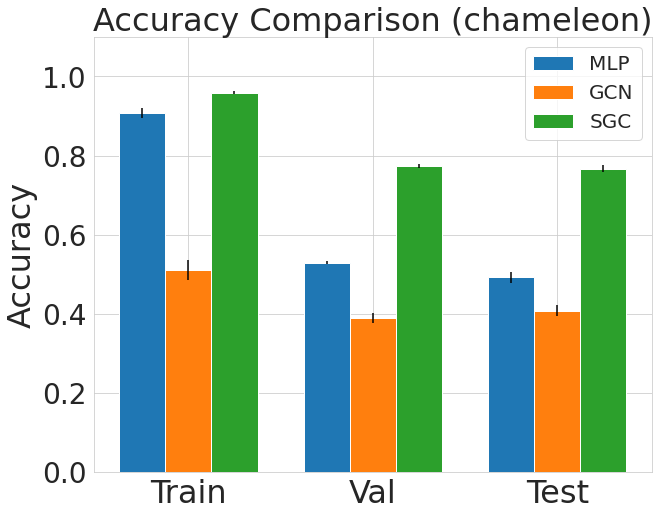

In [9]:
bar_labels = ["MLP", "GCN", "SGC"]
n_models = len(bar_labels)
x = np.arange(3)
width = 0.25
bars = []
for i in range(n_models):
    plt.bar(x + (i - int(n_models / 2)) * width, [train_accs_10[i][0], val_accs_10[i][0], test_accs_10[i][0]], 
            width, yerr=[train_accs_10[i][1], val_accs_10[i][1], test_accs_10[i][1]], label=bar_labels[i])
plt.ylim(0, 1.1)
plt.ylabel('Accuracy', fontsize=32)
plt.yticks(fontsize=28)
plt.xticks(ticks=x, labels=["Train", "Val", "Test"], fontsize=32)
plt.title('Accuracy Comparison ({})'.format(dataset_name), fontsize=32)
plt.legend(fontsize=20)
plt.savefig(os.path.join(figure_dir, "acc_{}.png".format(dataset_name)), bbox_inches='tight')
plt.show()

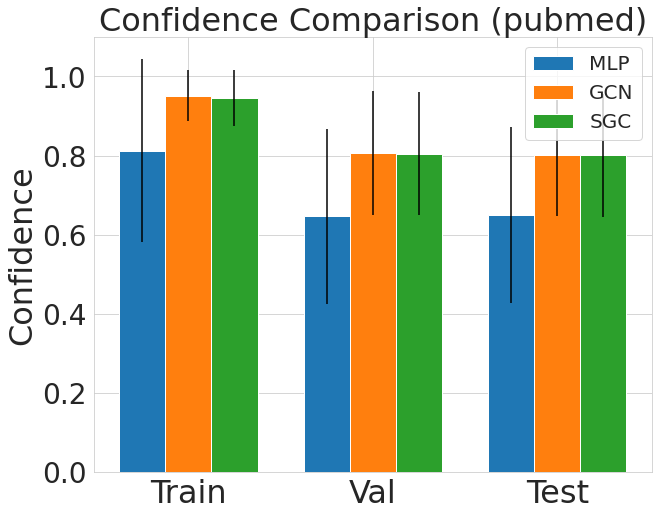

In [9]:
bar_labels = ["MLP", "GCN", "SGC"]
n_models = len(bar_labels)
x = np.arange(3)
width = 0.25
bars = []
for i in range(n_models):
    y = [train_confs_10[i][0], val_confs_10[i][0], test_confs_10[i][0]]
    yerr = [train_confs_10[i][1], val_confs_10[i][1], test_confs_10[i][1]]
    plt.bar(x + (i - int(n_models / 2)) * width, y, width, yerr=yerr, label=bar_labels[i])
plt.ylim(0, 1.1)
plt.ylabel('Confidence', fontsize=32)
plt.yticks(fontsize=28)
plt.xticks(ticks=x, labels=["Train", "Val", "Test"], fontsize=32)
plt.title('Confidence Comparison ({})'.format(dataset_name), fontsize=32)
plt.legend(fontsize=20)
plt.savefig(os.path.join(figure_dir, "confidence_{}.png".format(dataset_name)), bbox_inches='tight')
plt.show()

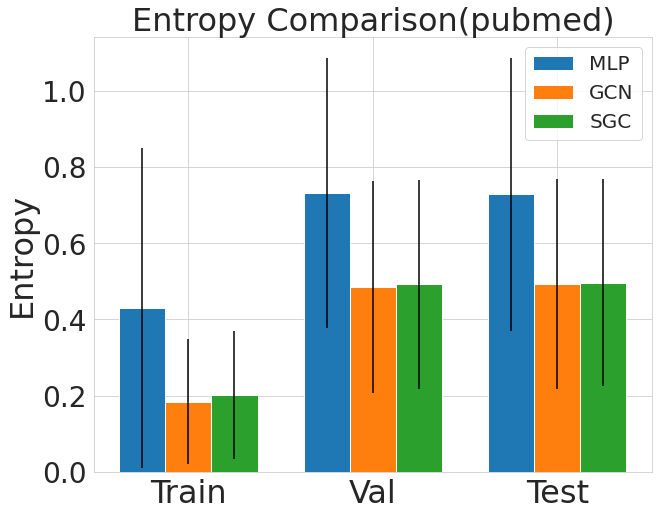

In [10]:
bar_labels = ["MLP", "GCN", "SGC"]
n_models = len(bar_labels)
x = np.arange(3)
width = 0.25
bars = []
for i in range(n_models):
    y = [train_entropys_10[i][0], val_entropys_10[i][0], test_entropys_10[i][0]]
    yerr = [train_entropys_10[i][1], val_entropys_10[i][1], test_entropys_10[i][1]]
    plt.bar(x + (i - int(n_models / 2)) * width, y, width, yerr=yerr, label=bar_labels[i])
plt.ylabel('Entropy', fontsize=32)
plt.yticks(fontsize=28)
plt.xticks(ticks=x, labels=["Train", "Val", "Test"], fontsize=32)
plt.title('Entropy Comparison({})'.format(dataset_name), fontsize=32)
plt.legend(fontsize=20)
plt.savefig(os.path.join(figure_dir, "entropy_{}.png".format(dataset_name)), bbox_inches='tight')
plt.show()

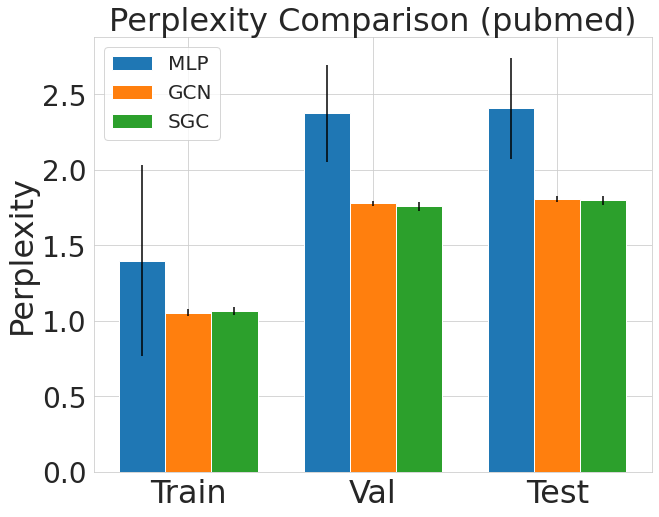

In [11]:
bar_labels = ["MLP", "GCN", "SGC"]
n_models = len(bar_labels)
x = np.arange(3)
width = 0.25
bars = []
for i in range(n_models):
    plt.bar(x + (i - int(n_models / 2)) * width, [train_perps_10[i][0], val_perps_10[i][0], test_perps_10[i][0]], width,  
            yerr=[train_perps_10[i][1], val_perps_10[i][1], test_perps_10[i][1]], label=bar_labels[i])
plt.ylabel('Perplexity', fontsize=32)
plt.yticks(fontsize=28)
plt.xticks(ticks=x, labels=["Train", "Val", "Test"], fontsize=32)
plt.title('Perplexity Comparison ({})'.format(dataset_name), fontsize=32)
plt.legend(fontsize=20)
plt.savefig(os.path.join(figure_dir, "perplexity_{}.png".format(dataset_name)), bbox_inches='tight')
plt.show()

### Post Augmentation

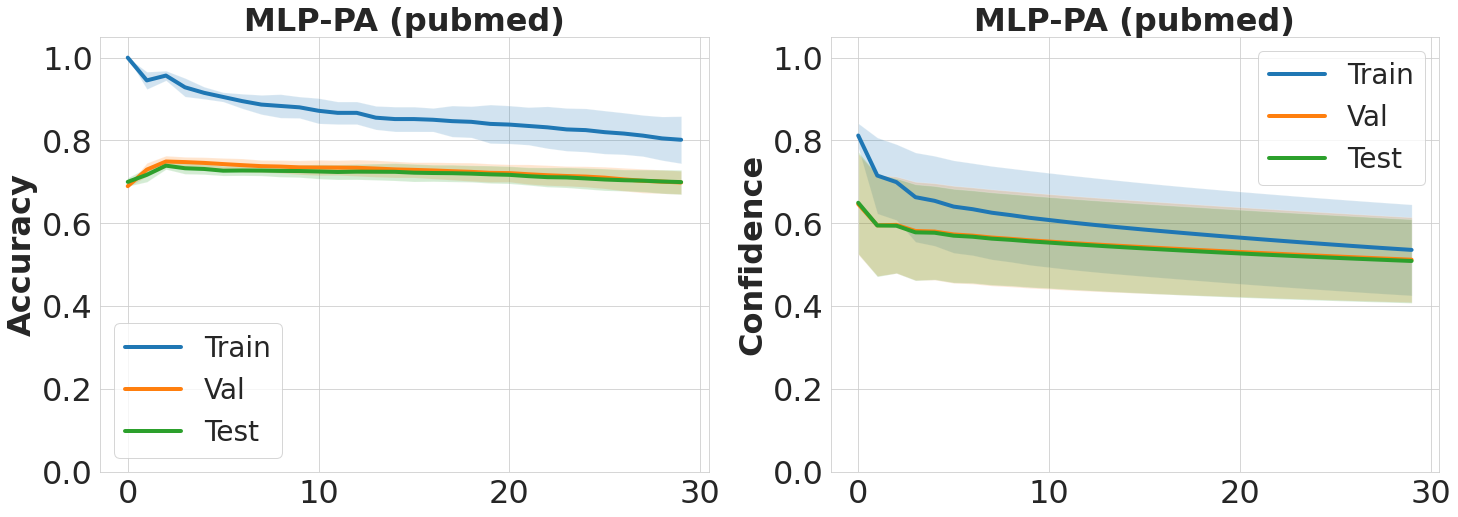

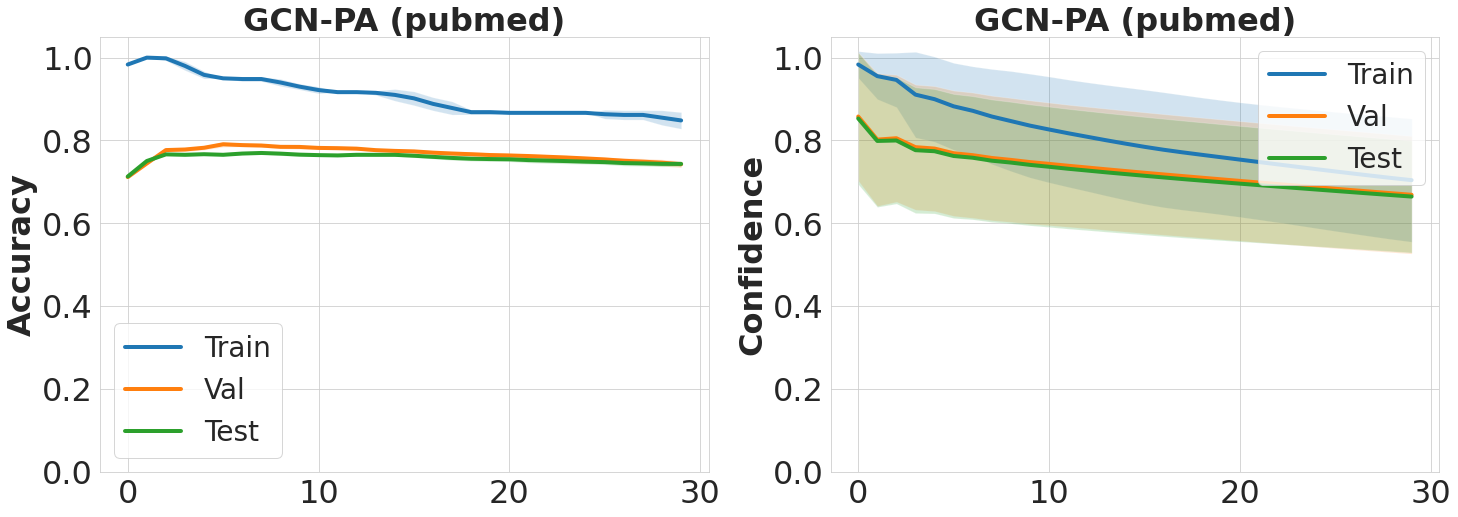

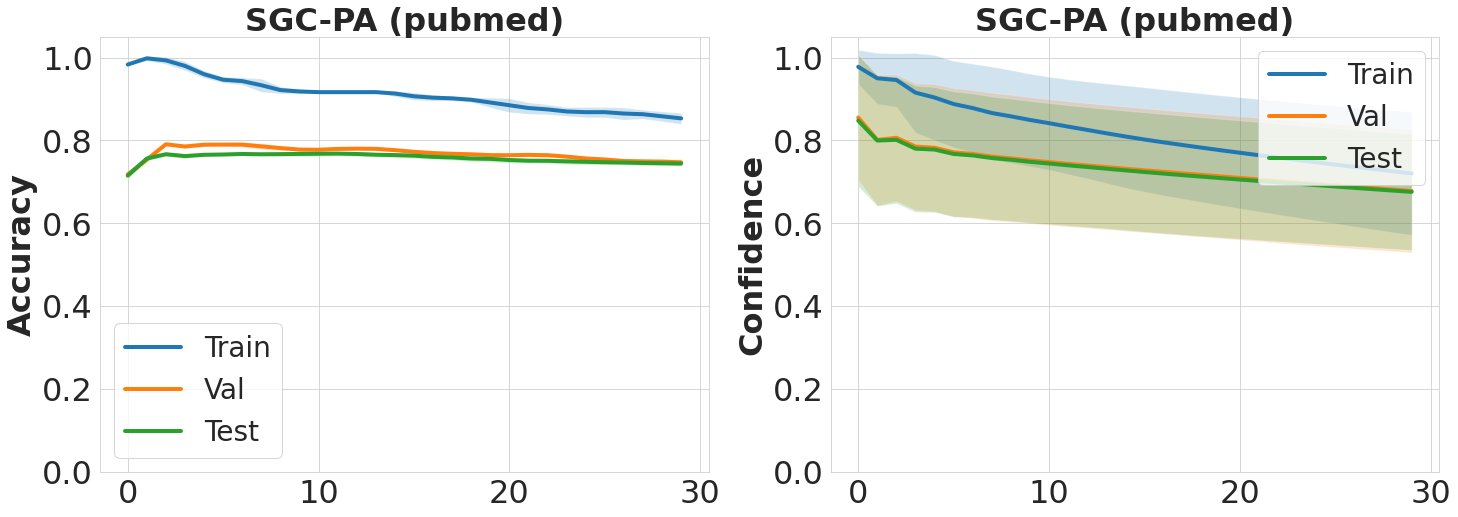

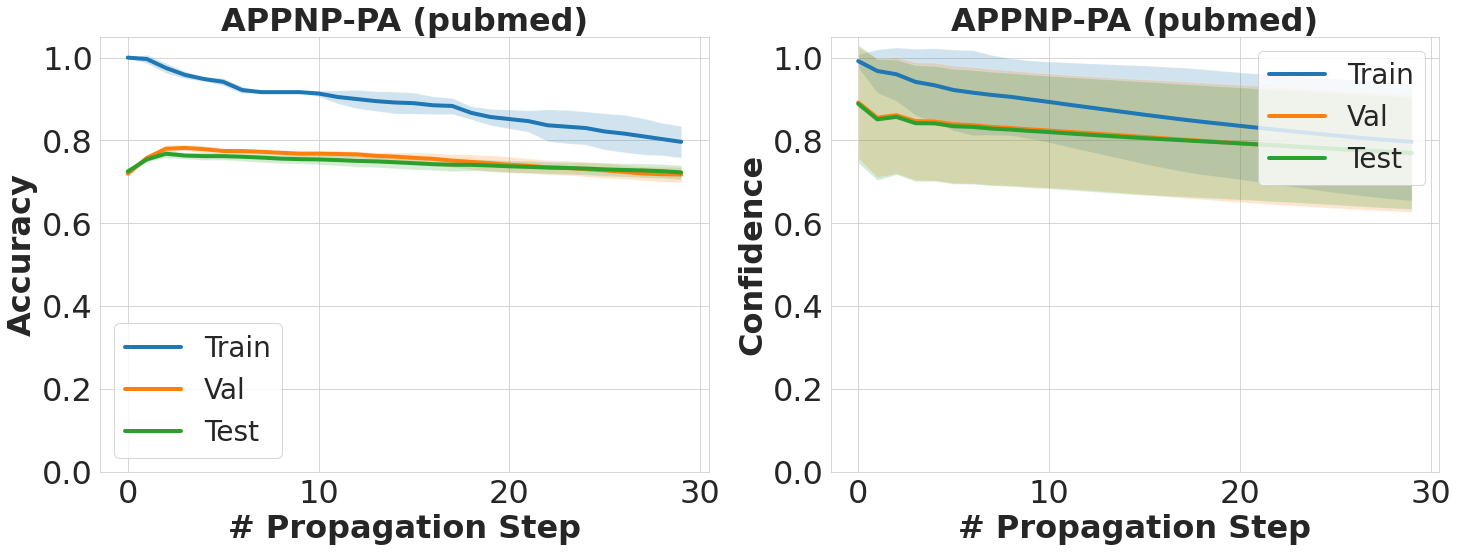

In [20]:
n_post = 30
for k in models_dict.keys():
    model_name = k.upper()
    post_props = np.arange(n_post)
    train_accs_10, val_accs_10, test_accs_10 = [], [], []
    train_conf_means_10, train_conf_stds_10 = [], []
    val_conf_means_10, val_conf_stds_10 = [], []
    test_conf_means_10, test_conf_stds_10 = [], []
    for seed in range(10):
        model = models_dict[k]['seed_{}'.format(seed)]['model']
        x_post = copy.deepcopy(dataset.data.x)
        graph = copy.deepcopy(dataset.data)
        if remove_self_loop:
            graph.remove_self_loops()
        else:
            graph.add_remaining_self_loops()
        graph.sym_norm()
        train_accs, val_accs, test_accs = [], [], []
        train_conf_means, train_conf_stds = [], []
        val_conf_means, val_conf_stds = [], []
        test_conf_means, test_conf_stds = [], []
        train_entropy_means, train_entropy_stds = [], []
        val_entropy_means, val_entropy_stds = [], []
        test_entropy_means, test_entropy_stds = [], []
        for n_post_prop in post_props:
            if 'mlp' in k.lower():
                pred = model.forward(x_post)
            else:
                graph = copy.deepcopy(dataset.data)
                if remove_self_loop:
                    graph.remove_self_loops()
                else:
                    graph.add_remaining_self_loops()
                graph.x = x_post
                graph.sym_norm()
                pred = model.embed_without_prop(graph, 2)

            # Get accuracy
            train_acc, val_acc, test_acc = utils.eval_acc(pred, dataset, verbose=False)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            test_accs.append(test_acc)
            # Get confidence
            train_confidence, val_confidence, test_confidence = utils.eval_confidence(pred, dataset, verbose=False)
            train_conf_means.append(torch.mean(train_confidence).item())
            val_conf_means.append(torch.mean(val_confidence).item())
            test_conf_means.append(torch.mean(test_confidence).item())
            train_conf_stds.append(torch.std(train_confidence).item())
            val_conf_stds.append(torch.std(val_confidence).item())
            test_conf_stds.append(torch.std(test_confidence).item())
            # Get entropy
            train_entropy, val_entropy, test_entropy = utils.eval_entropy(pred, dataset, verbose=False)
            train_entropy_means.append(torch.mean(train_entropy).item())
            val_entropy_means.append(torch.mean(val_entropy).item())
            test_entropy_means.append(torch.mean(test_entropy).item())
            train_entropy_stds.append(torch.std(train_entropy).item())
            val_entropy_stds.append(torch.std(val_entropy).item())
            test_entropy_stds.append(torch.std(test_entropy).item())
            x_post = spmm(graph, x_post)
        train_accs_10.append(train_accs)
        val_accs_10.append(val_accs)
        test_accs_10.append(test_accs)
        train_conf_means_10.append(train_conf_means)
        train_conf_stds_10.append(train_conf_stds)
        val_conf_means_10.append(val_conf_means)
        val_conf_stds_10.append(val_conf_stds)
        test_conf_means_10.append(test_conf_means)
        test_conf_stds_10.append(test_conf_stds)
    
    train_acc_mean, train_acc_std = torch.tensor(train_accs_10).mean(dim=0).numpy(), torch.tensor(train_accs_10).std(dim=0).numpy()
    val_acc_mean, val_acc_std = torch.tensor(val_accs_10).mean(dim=0).numpy(), torch.tensor(val_accs_10).std(dim=0).numpy()
    test_acc_mean, test_acc_std = torch.tensor(test_accs_10).mean(dim=0).numpy(), torch.tensor(test_accs_10).std(dim=0).numpy()
    
    fig, axs = plt.subplots(1, 2, figsize=(24, 8))
    axs[0].plot(post_props, train_acc_mean, linewidth=4, label="Train")
    axs[0].fill_between(post_props, train_acc_mean - train_acc_std, 
                        train_acc_mean + train_acc_std, alpha=0.2)
    axs[0].plot(post_props, val_acc_mean, linewidth=4, label="Val")
    axs[0].fill_between(post_props, val_acc_mean - val_acc_std, 
                        val_acc_mean + val_acc_std, alpha=0.2)
    axs[0].plot(post_props, test_acc_mean, linewidth=4, label="Test")
    axs[0].fill_between(post_props, test_acc_mean - test_acc_std, 
                        test_acc_mean + test_acc_std, alpha=0.2)
    axs[0].set_title("{}-PA ({})".format(model_name, dataset_name), fontsize=32, fontweight='bold')
    axs[0].set_ylim(0, 1.05)
    axs[0].set_ylabel("Accuracy", fontsize=32, fontweight='bold')
    if 'appnp' in k.lower():
        axs[0].set_xlabel("# Propagation Step", fontsize=32, fontweight='bold')
    axs[0].tick_params(axis="x", labelsize=32)
    axs[0].tick_params(axis="y", labelsize=32)
    axs[0].legend(fontsize=28, loc=3)
 
    # axs[0].savefig("./figures/post_{}_{}.png".format(dataset_name, models_dict[k]['name']), bbox_inches='tight')
    
    train_conf_mean, train_conf_std = torch.tensor(train_conf_means_10).mean(dim=0).numpy(), torch.tensor(train_conf_stds_10).mean(dim=0).numpy()
    val_conf_mean, val_conf_std = torch.tensor(val_conf_means_10).mean(dim=0).numpy(), torch.tensor(val_conf_stds_10).mean(dim=0).numpy()
    test_conf_mean, test_conf_std = torch.tensor(test_conf_means_10).mean(dim=0).numpy(), torch.tensor(test_conf_stds_10).mean(dim=0).numpy()
    
    axs[1].plot(post_props, train_conf_mean, linewidth=4, label="Train")
    axs[1].fill_between(post_props, train_conf_mean - train_conf_std, 
                        train_conf_mean + train_conf_std, alpha=0.2)
    axs[1].plot(post_props, val_conf_mean, linewidth=4, label="Val")
    axs[1].fill_between(post_props, val_conf_mean - val_conf_std, 
                        val_conf_mean + val_conf_std, alpha=0.2)
    axs[1].plot(post_props, test_conf_mean, linewidth=4, label="Test")
    axs[1].fill_between(post_props, test_conf_mean - test_conf_std, 
                        test_conf_mean + test_conf_std, alpha=0.2)
    axs[1].set_title("{}-PA ({})".format(model_name, dataset_name), fontsize=32, fontweight='bold')
    axs[1].set_ylim(0, 1.05)
    axs[1].set_ylabel("Confidence", fontsize=32, fontweight='bold')
    if 'appnp' in k.lower():
        axs[1].set_xlabel("# Propagation Step", fontsize=32, fontweight='bold')
    axs[1].tick_params(axis="x", labelsize=32)
    axs[1].tick_params(axis="y", labelsize=32)
    axs[1].legend(fontsize=28, loc=1)
    # plt.savefig(os.path.join(figure_dir, "post_aug_{}_{}.png".format(dataset_name, model_name)), bbox_inches='tight')
    plt.show()